In [ ]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.autograd as autograd
from torch.autograd import Variable
from collections import deque, namedtuple
import matplotlib.pyplot as plt

In [ ]:
import glob
import io
import base64
import imageio
from IPython.display import HTML, display,Video

Installing dependencies

In [ ]:
!pip install gymnasium
!apt-get install -y swig
!apt-get install -y build-essential python3-dev
!pip install box2d-py
!pip install gym[box2d]
!pip install imageio

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
swig is already the newest version (4.0.2-1ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
build-essential is already the newest version (12.9ubuntu3).
python3-dev is already the newest version (3.10.6-1~22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
class Network(nn.Module):
    def __init__(self, state_size, action_size, seed=42):
        super(Network, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, action_size)
        self.bn1 = nn.BatchNorm1d(128)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(64)

    def forward(self, state):
        x = self.fc1(state)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = self.bn3(x)
        x = F.relu(x)
        return self.fc4(x)


import gymnasium as gym
env = gym.make('LunarLander-v3')
state_shape = env.observation_space.shape
state_size = env.observation_space.shape[0]
number_actions = env.action_space.n

learning_rate = 1e-4
minibatch_size = 64
discount_factor = 0.99
replay_buffer_size = int(1e5)
interpolation_parameter = 5e-3
update_every = 4

In [ ]:
class ReplayMemory(object):
    def __init__(self, capacity):
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, event):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = event
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        experiences = random.sample(self.memory, k=batch_size)
        states = torch.from_numpy(np.vstack([e[0] for e in experiences if e is not None])).float().to(self.device)
        actions = torch.from_numpy(np.vstack([e[1] for e in experiences if e is not None])).long().to(self.device)
        rewards = torch.from_numpy(np.vstack([e[2] for e in experiences if e is not None])).float().to(self.device)
        next_states = torch.from_numpy(np.vstack([e[3] for e in experiences if e is not None])).float().to(self.device)
        dones = torch.from_numpy(np.vstack([e[4] for e in experiences if e is not None]).astype(np.uint8)).float().to(self.device)
        return states, next_states, actions, rewards, dones

    def __len__(self):
        return len(self.memory)

In [ ]:
def save_video_of_model(agent, env_name, video_name='video.mp4'):
    """Save a video of the agent interacting with the environment."""
    env = gym.make(env_name, render_mode='rgb_array')
    state, _ = env.reset()
    done = False
    frames = []
    while not done:
        frame = env.render()
        frames.append(frame)
        action = agent.act(state)
        state, reward, done, _, _ = env.step(action.item())
    env.close()
    # Save the video to a file
    imageio.mimsave(video_name, frames, fps=30)
    print(f"Video saved as {video_name}")

In [ ]:
class Agent:
    def __init__(self, state_size, action_size):
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.state_size = state_size
        self.action_size = action_size
        self.local_qnetwork = Network(state_size, action_size).to(self.device)
        self.target_qnetwork = Network(state_size, action_size).to(self.device)
        self.optimizer = optim.Adam(self.local_qnetwork.parameters(), lr=learning_rate)
        self.memory = ReplayMemory(replay_buffer_size)
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):
        self.memory.push((state, action, reward, next_state, done))
        self.t_step = (self.t_step + 1) % update_every
        if self.t_step == 0:
            if len(self.memory) > minibatch_size:
                experiences = self.memory.sample(minibatch_size)
                self.learn(experiences, discount_factor)

    def act(self, state, epsilon=0.):
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        self.local_qnetwork.eval()
        with torch.no_grad():
            action_values = self.local_qnetwork(state)
        self.local_qnetwork.train()
        if random.random() > epsilon:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, discount_factor):
        states, next_states, actions, rewards, dones = experiences
        self.local_qnetwork.eval()
        with torch.no_grad():
            best_actions = self.local_qnetwork(next_states).argmax(1).unsqueeze(1)
            next_qtargets = self.target_qnetwork(next_states).gather(1, best_actions)
        self.local_qnetwork.train()
        q_targets = rewards + (discount_factor * next_qtargets * (1 - dones))
        q_expected = self.local_qnetwork(states).gather(1, actions)
        loss = F.huber_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.local_qnetwork.parameters(), 1)
        self.optimizer.step()
        self.soft_update(self.local_qnetwork, self.target_qnetwork, interpolation_parameter)
    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)


agent = Agent(state_size,number_actions)

number_episodes = 2000
maximum_num_t_steps = 1000
epsilon_starting_value = 1.0
epsilon_ending_value = 0.01
epsilon_decay_value = 0.995
epsilon = epsilon_starting_value
scores_on_100_episodes = deque(maxlen=100)

scores = []
for episode in range(1, number_episodes + 1):
    state, _ = env.reset()
    score = 0
    for t in range(maximum_num_t_steps):
        action = agent.act(state, epsilon)
        next_state, reward, done, _, _ = env.step(action)
        reward = np.clip(reward, -1, 1)
        agent.step(state, action, reward, next_state, done)
        state = next_state
        score += reward
        if done:
            break

    scores_on_100_episodes.append(score)
    epsilon = max(epsilon_ending_value, epsilon_decay_value * epsilon)

    print(f'\rEpisode {episode}\tAverage score: {np.mean(scores_on_100_episodes):.2f}', end="")
    if episode % 100 == 0:
        print(f'\rEpisode {episode}\tAverage score: {np.mean(scores_on_100_episodes):.2f}')
    if episode == 10:
        video_name = f'episode_{episode}.mp4'
        save_video_of_model(agent, 'LunarLander-v3', video_name=video_name)
        display(Video(video_name, embed=True))
    if episode == 50:
        video_name = f'episode_{episode}.mp4'
        save_video_of_model(agent, 'LunarLander-v3', video_name=video_name)
        display(Video(video_name, embed=True))
    if episode == 200:
        video_name = f'episode_{episode}.mp4'
        save_video_of_model(agent, 'LunarLander-v3', video_name=video_name)
        display(Video(video_name, embed=True))
    if episode == 500:
        video_name = f'episode_{episode}.mp4'
        save_video_of_model(agent, 'LunarLander-v3', video_name=video_name)
        display(Video(video_name, embed=True))
    if episode == 1000:
        video_name = f'episode_{episode}.mp4'
        save_video_of_model(agent, 'LunarLander-v3', video_name=video_name)
        display(Video(video_name, embed=True))
    if episode == 1500:
        video_name = f'episode_{episode}.mp4'
        save_video_of_model(agent, 'LunarLander-v3', video_name=video_name)
        display(Video(video_name, embed=True))
    if episode == 2000:
        video_name = f'episode_{episode}.mp4'
        save_video_of_model(agent, 'LunarLander-v3', video_name=video_name)
        display(Video(video_name, embed=True))
    scores.append(np.mean(scores_on_100_episodes))
    if np.mean(scores_on_100_episodes) >= 200.0:
        print(f'\nEnvironment solved in {episode - 100} episodes! Average score: {np.mean(scores_on_100_episodes):.2f}')
        torch.save(agent.local_qnetwork.state_dict(), 'checkpoint.pth')
        break


Episode 10	Average score: -36.60

Video saved as episode_10.mp4


Episode 50	Average score: -34.94

Video saved as episode_50.mp4


Episode 100	Average score: -26.53
Episode 200	Average score: -0.50


Video saved as episode_200.mp4


Episode 300	Average score: 13.20
Episode 400	Average score: 30.34
Episode 500	Average score: 43.19


Video saved as episode_500.mp4


Episode 600	Average score: 50.69
Episode 700	Average score: 58.16
Episode 800	Average score: 60.59
Episode 900	Average score: 56.12
Episode 1000	Average score: 54.22


Video saved as episode_1000.mp4


Episode 1100	Average score: 51.26
Episode 1200	Average score: 51.83
Episode 1300	Average score: 49.62
Episode 1400	Average score: 58.58
Episode 1500	Average score: 58.57


Video saved as episode_1500.mp4


Episode 1600	Average score: 52.61
Episode 1700	Average score: 46.55
Episode 1800	Average score: 42.31
Episode 1900	Average score: 44.76
Episode 2000	Average score: 43.20


Video saved as episode_2000.mp4


# **Graph**

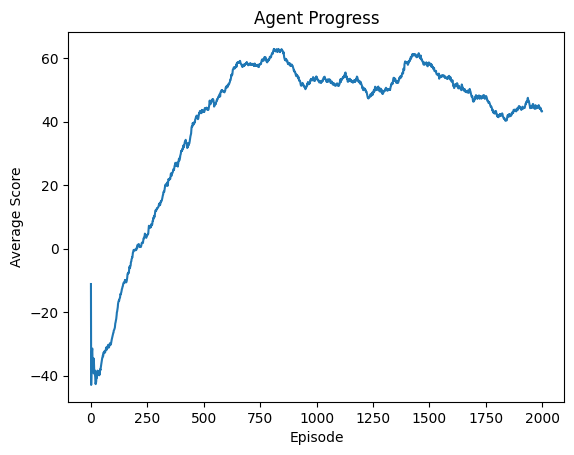

In [ ]:
plt.plot(scores)
plt.xlabel('Episode')
plt.ylabel('Average Score')
plt.title('Agent Progress')
plt.show()